In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import optuna
import joblib

### EDA

In [67]:
data_train = pd.read_csv('data/train.csv')
data_train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080


Поскольку таргет в тестовой части нам неизвестен, выделим часть трейновой части для валидации созданных моделей

In [68]:
X = data_train.drop('Price', axis=1)
y = data_train['Price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=8)

Пропуски в данных

In [69]:
# Сразу удалим признак id как не несущий полезной информации
X_train = X_train.drop('id', axis=1)
X_val = X_val.drop('id', axis=1)

X_train.isna().sum()

Brand                   7294
Material                6268
Size                    4914
Compartments               0
Laptop Compartment      5561
Waterproof              5215
Style                   5913
Color                   7514
Weight Capacity (kg)     111
dtype: int64

In [70]:
X_val.isna().sum()

Brand                   2411
Material                2079
Size                    1681
Compartments               0
Laptop Compartment      1883
Waterproof              1835
Style                   2057
Color                   2436
Weight Capacity (kg)      27
dtype: int64

In [71]:
X_train.describe(include='object')

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
count,217706,218732,220086,219439,219785,219087,217486
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,45200,59720,76552,111344,111100,75040,38813


In [72]:
X_train.describe()

,Compartments,Weight Capacity (kg)
count,225000.000000,224889.000000
mean,5.442538,18.040247
std,2.891775,6.972472
min,1.000000,5.000000
25%,3.000000,12.099788
50%,5.000000,18.077288
75%,8.000000,24.038977
max,10.000000,30.000000


In [73]:
# Заменим пропущенные данные в категориальных признаках на `no info`
categorical_cols = X_train.select_dtypes('object').columns.to_list()
X_train[categorical_cols] = X_train[categorical_cols].fillna('no info')
X_val[categorical_cols] = X_val[categorical_cols].fillna('no info')

# Заменим пропущенные данные в числовых признаках на медиану
numerical_cols = X_train.select_dtypes([int, float]).columns.to_list()
median = X_train['Weight Capacity (kg)'].median()

X_train['Weight Capacity (kg)'] = X_train['Weight Capacity (kg)'].fillna(median)
X_val['Weight Capacity (kg)'] = X_val['Weight Capacity (kg)'].fillna(median)

Выбросы

<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

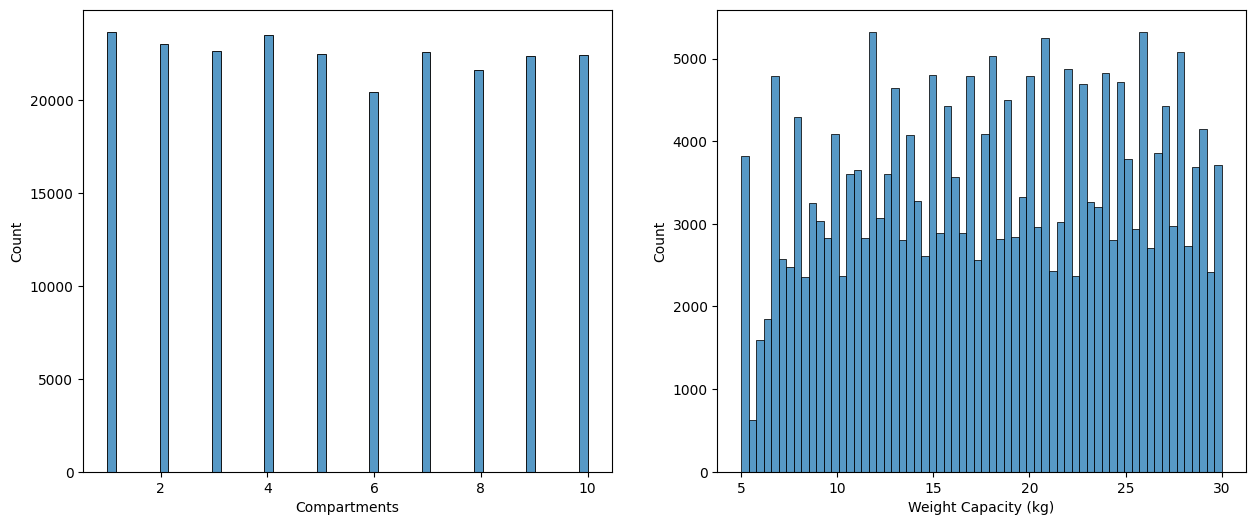

In [74]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))
sns.histplot(data=X_train, x='Compartments',ax=axes[0])
sns.histplot(data=X_train, x='Weight Capacity (kg)',ax=axes[1])

In [75]:
mask = X_train.isin([18.077287627013348]).any(axis=1)

# Фильтруем DataFrame, используя маску
res = X_train.loc[mask]
res

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
99341,Nike,no info,no info,1.0,Yes,Yes,Backpack,Red,18.077288
132688,Nike,Nylon,no info,3.0,no info,No,Messenger,Blue,18.077288
297801,Adidas,Nylon,Small,1.0,Yes,no info,Backpack,Red,18.077288
188479,Puma,Polyester,Medium,3.0,No,no info,Tote,Red,18.077288
114741,no info,Polyester,Medium,1.0,Yes,No,no info,Pink,18.077288
...,...,...,...,...,...,...,...,...,...
213757,Puma,Nylon,Medium,2.0,No,Yes,no info,Pink,18.077288
34876,Adidas,Polyester,Large,6.0,Yes,no info,Tote,Pink,18.077288
179151,Adidas,Nylon,no info,4.0,No,no info,Tote,Gray,18.077288
40845,no info,no info,Large,9.0,Yes,No,Backpack,Gray,18.077288


Корреляции

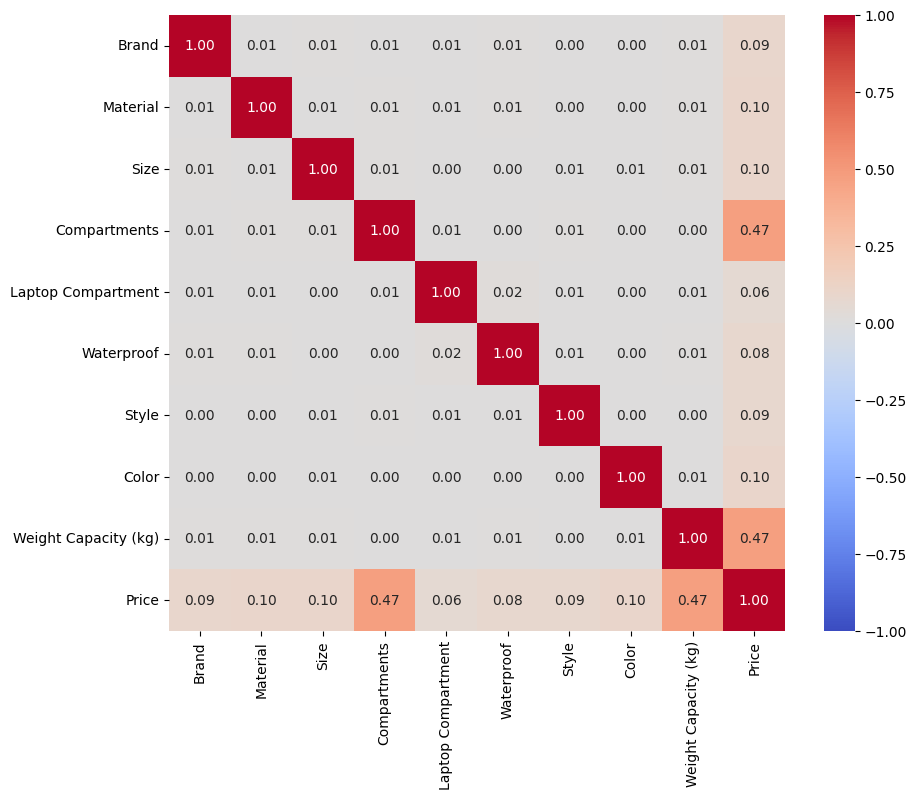

{'corr':                          Brand  Material      Size  Compartments  \
 Brand                 1.000000  0.006802  0.008535      0.006241   
 Material              0.006802  1.000000  0.007605      0.010200   
 Size                  0.008535  0.007605  1.000000      0.009060   
 Compartments          0.006241  0.010200  0.009060      1.000000   
 Laptop Compartment    0.005788  0.007122  0.004969      0.006729   
 Waterproof            0.009582  0.008387  0.002548      0.004548   
 Style                 0.003983  0.004910  0.005546      0.009883   
 Color                 0.001557  0.003665  0.006191      0.003475   
 Weight Capacity (kg)  0.010872  0.010589  0.009831      0.002435   
 Price                 0.090907  0.095774  0.095092      0.469131   
 
                       Laptop Compartment  Waterproof     Style     Color  \
 Brand                           0.005788    0.009582  0.003983  0.001557   
 Material                        0.007122    0.008387  0.004910  0.003665   


In [76]:
from dython.nominal import associations

# Вычисляем корреляции категориальных данных для
associations(pd.concat([X_train, y_train], axis=1),
             nominal_columns=categorical_cols, \
              numerical_columns=numerical_cols,\
              figsize=(10, 8), cmap='coolwarm')

### Baseline

In [77]:
X_train.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
257342,Adidas,Canvas,Large,7.0,No,Yes,Messenger,Pink,8.667768
1230,Adidas,Leather,no info,8.0,No,Yes,Messenger,Blue,15.085735
126968,Under Armour,Canvas,Small,2.0,No,Yes,Tote,Gray,24.907312
136997,Nike,Nylon,Medium,1.0,Yes,Yes,Backpack,Green,17.132315
162570,Jansport,Polyester,Small,2.0,Yes,No,Backpack,Red,29.558365


In [150]:
# Преобразование числовых столбцов
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Масштабирование непрерывных числовых признаков
])

categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder())  # Масштабирование категориальных признаков
])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {'regressor__alpha': np.logspace(-1, 2, 10)}

# Настройка GridSearchCV
gs_lr = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

# Обучаем модели с различными гиперпараметрами
gs_lr.fit(X_train, y_train)


y_pred = gs_lr.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'Target mean value: {y_val.mean():.3f}')
print(gs_lr.best_params_)

RMSE: 38.974
Target mean value: 81.436
{'regressor__alpha': 100.0}


In [149]:
np.logspace(-1, 2, 10)

array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ])

### Catboost

In [106]:
cb = CatBoostRegressor(cat_features=categorical_cols, logging_level='Silent')

cb.fit(X_train, y_train)
y_pred = cb.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'Target mean value: {y_val.mean():.3f}')

RMSE: 38.967
Target mean value: 81.436


### CatBoost + Optuna

In [166]:
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    iterations = trial.suggest_int('iterations', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    depth = trial.suggest_int('depth', 4, 12)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 1.0, log=True)


    # Создаем модель
    model = CatBoostRegressor(iterations=iterations,
                              depth=depth,
                              learning_rate=learning_rate,
                              l2_leaf_reg=l2_leaf_reg,
                              cat_features=categorical_cols,
                              logging_level='Silent')


    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    return rmse

In [167]:
# Создаем Bayesian Optimization
study_cb = optuna.create_study()

# Запускаем Bayesian Optimization
study_cb.optimize(objective, n_trials=30)

best_params_cb = study_cb.best_params

[I 2025-02-23 22:16:33,723] A new study created in memory with name: no-name-7268379b-9f01-4628-a2fc-1dc2b920290b
[I 2025-02-23 22:16:51,501] Trial 0 finished with value: 38.96730683306741 and parameters: {'iterations': 407, 'learning_rate': 0.01026662193513447, 'depth': 7, 'l2_leaf_reg': 0.015178411816283056}. Best is trial 0 with value: 38.96730683306741.
[I 2025-02-23 22:17:29,936] Trial 1 finished with value: 38.99316299344894 and parameters: {'iterations': 386, 'learning_rate': 0.07108226253996164, 'depth': 10, 'l2_leaf_reg': 0.026738707111048948}. Best is trial 0 with value: 38.96730683306741.
[I 2025-02-23 22:17:42,879] Trial 2 finished with value: 38.96511581389527 and parameters: {'iterations': 337, 'learning_rate': 0.023678850282528374, 'depth': 6, 'l2_leaf_reg': 0.09674892145687039}. Best is trial 2 with value: 38.96511581389527.
[I 2025-02-23 22:18:27,841] Trial 3 finished with value: 38.96557493433227 and parameters: {'iterations': 441, 'learning_rate': 0.01474563715150710

In [168]:
# Создаем модель с лучшими гиперпараметрами
best_cb_model = CatBoostRegressor(cat_features=categorical_cols,
                                logging_level='Silent',
                               **best_params_cb)

best_cb_model.fit(X_train, y_train)

joblib.dump(best_cb_model,'best_cb_model.joblib')

y_pred = best_cb_model.predict(X_val)
rmse_optuna = root_mean_squared_error(y_val, y_pred)

print(f'CatBoost + optuna RMSE: {rmse_optuna:.5f}')

CatBoost + optuna RMSE: 38.96102


### RandomForest

In [122]:
# Кодируем категориальные признаки при помощи OneHotEncoder
ohe_enc = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False).set_output(transform='pandas')

X_train_encoded = ohe_enc.fit_transform(X_train[categorical_cols])
X_val_encoded = ohe_enc.transform(X_val[categorical_cols])

def objective_rf(trial):
    # Определите гиперпараметры для подбора
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 16),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train_encoded, y_train)

    y_pred = model.predict(X_val_encoded)
    rmse = root_mean_squared_error(y_val, y_pred)

    return rmse

# Запуск оптимизации
study_rf = optuna.create_study()
study_rf.optimize(objective_rf, n_trials=30)
best_params_rf = study_rf.best_params

[I 2025-02-23 19:04:31,092] A new study created in memory with name: no-name-bf2b761c-0b2c-4ab6-9b7d-576b12e9eee4
[I 2025-02-23 19:05:45,539] Trial 0 finished with value: 39.24684751270083 and parameters: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 39.24684751270083.
[I 2025-02-23 19:06:07,412] Trial 1 finished with value: 38.980634003760564 and parameters: {'n_estimators': 136, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 1 with value: 38.980634003760564.
[I 2025-02-23 19:06:58,088] Trial 2 finished with value: 39.18837685159833 and parameters: {'n_estimators': 170, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 1 with value: 38.980634003760564.
[I 2025-02-23 19:07:26,449] Trial 3 finished with value: 38.98008322913543 and parameters: {'n_estimators': 177, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 3 with value: 38.

In [123]:
best_rf_model = RandomForestRegressor(**best_params_rf)
best_rf_model.fit(X_train_encoded, y_train)

joblib.dump(best_rf_model,'best_rf_model.joblib')

y_pred = best_rf_model.predict(X_val_encoded)
rmse_optuna = root_mean_squared_error(y_val, y_pred)

print(f'RandomForest + optuna RMSE: {rmse_optuna:.5f}')

RandomForest + optuna RMSE: 38.98069


### XGBoost

In [165]:
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    params={
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 2, 100),
        'gamma': trial.suggest_float('gamma', 0.01, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Создаем модель
    model = XGBRegressor(**params)
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_val_encoded)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

# Создаем Bayesian Optimization
study = optuna.create_study()
# Запускаем Bayesian Optimization
study.optimize(objective, n_trials=100)
best_params_xgb = study.best_params
# Создаем модель с лучшими гиперпараметрами
xgb_model = XGBRegressor(**best_params_xgb)
xgb_model.fit(X_train_encoded, y_train)

y_pred = xgb_model.predict(X_val_encoded)
rmse_optuna = root_mean_squared_error(y_val, y_pred)

print(f'XGBoost + optuna RMSE: {rmse_optuna:.5f}')

[I 2025-02-23 22:14:51,026] A new study created in memory with name: no-name-9044dc48-fe1f-4662-a71f-6d7fa837c1e9
[I 2025-02-23 22:14:51,305] Trial 0 finished with value: 38.993380534234724 and parameters: {'max_depth': 9, 'learning_rate': 0.10759839199638926, 'n_estimators': 18, 'gamma': 1.4793479359903403, 'subsample': 0.552963843151858, 'colsample_bytree': 0.5602099336216215, 'reg_alpha': 0.025474899962931227, 'reg_lambda': 2.0894815474897914, 'min_child_weight': 10}. Best is trial 0 with value: 38.993380534234724.
[I 2025-02-23 22:14:51,440] Trial 1 finished with value: 38.9847191341065 and parameters: {'max_depth': 1, 'learning_rate': 0.21380132861518578, 'n_estimators': 23, 'gamma': 0.5266459776302775, 'subsample': 0.5126977740569963, 'colsample_bytree': 0.5473104493188097, 'reg_alpha': 7.333491882550951, 'reg_lambda': 0.4190200978685304, 'min_child_weight': 2}. Best is trial 1 with value: 38.9847191341065.
[I 2025-02-23 22:14:51,900] Trial 2 finished with value: 38.9816716847421

XGBoost + optuna RMSE: 38.97569


### Stacking

In [124]:
# Создание пайплайна для Random Forest с One-Hot Encoding
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)

rf_model = joblib.load('best_rf_model.joblib')

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_rf),
                               ('model', rf_model)])

# Создание пайплайна для XGBoost с One-Hot Encoding
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)

# xgb_model = joblib.load('best_rf_model.joblib')

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor_xgb),
                               ('model', xgb_model)])

In [169]:
# Определите базовые модели

cb_model = joblib.load('best_cb_model.joblib')

base_models = [
    ('catboost', cb_model),
    ('random_forest', rf_pipeline),
]

# Мета-алгоритм
meta_model = Ridge(alpha=100)

# Создание стекинг-модели
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Обучение стекинг-модели
stacked_model.fit(X_train, y_train)

# Прогнозирование
predictions = stacked_model.predict(X_val)

In [170]:
rmse_stack = root_mean_squared_error(y_val, predictions)

print(f'Stacked models RMSE: {rmse_stack:.5f}')

Stacked models RMSE: 38.95970


### Test and submission

In [171]:
df_test = pd.read_csv('data/test.csv')
submission = pd.DataFrame()
submission['id'] = df_test['id']
X_test = df_test.drop('id', axis=1)

In [172]:
# Заменим пропущенные данные в категориальных признаках на `no info`
X_test[categorical_cols] = X_test[categorical_cols].fillna('no info')

# Заменим пропущенные данные в числовых признаках на медиану
X_test['Weight Capacity (kg)'] = X_test['Weight Capacity (kg)'].fillna(median)

In [173]:
y_pred = stacked_model.predict(X_test)
submission['Price'] = np.round(y_pred, 3)
submission.head()

,id,Price
0,300000,81.713
1,300001,82.939
2,300002,82.604
3,300003,80.836
4,300004,79.053


In [174]:
submission.to_csv('data/submission.csv', index=False)